<a href="https://colab.research.google.com/github/sharath1803/corteva_deployment/blob/main/MSI_MVP_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Dependencies
!pip install pystac_client --quiet
!pip install rioxarray --quiet
!pip install earthpy  --quiet
!pip install sentinelsat --quiet
!pip install -U kaleido
!pip install planetary_computer
!pip install -U geotable
#ngrok for exposing endpoint to the internet
!pip install fastapi nest-asyncio pyngrok uvicorn

In [2]:
#@title imports
import json
import os
import requests
import logging
import io
import gc

from shapely.geometry import Point, LineString, Polygon
import pystac_client
from pystac_client import Client
import rioxarray
import xarray as xr
import matplotlib.pyplot as plt
from rasterio.enums import Resampling
import numpy as np
import pandas as pd
from sentinelsat import SentinelAPI
from flask import Flask, request, render_template, url_for, make_response
from PIL import Image as im
import matplotlib.patches as patches
import geopandas as gpd
import pyproj
from pyproj import CRS
import multiprocessing
from multiprocessing import Process
from werkzeug.utils import redirect
from matplotlib.ticker import ScalarFormatter

import plotly.graph_objects as go
from jinja2.bccache import BytesIO
import dask.array as da
import shapely
from plotly.subplots import make_subplots
import geotable
from datetime import datetime
import glob
import rasterio
from scipy.spatial import Delaunay
from shapely.ops import cascaded_union
from geopandas import GeoDataFrame
from geopandas import read_file
from shapely.ops import unary_union
import cv2
from shapely.geometry import shape

from datetime import datetime, timedelta
import pytz
import math
import seaborn as sns
from sklearn.metrics import r2_score

import planetary_computer
from pystac.extensions.eo import EOExtension as eo
from PIL import Image

import os
from glob import glob
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import plotting_extent
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import tempfile
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
from fastapi.responses import FileResponse
from fastapi import Response
from typing import Tuple, List

In [3]:
#@title Constants
TEMPLATE = "/content/drive/MyDrive/ASCI/webpage/templates"
STATIC = "/content/drive/MyDrive/ASCI/webpage/static"
TEMP_FOLDER = "/content/drive/MyDrive/ASCI/webpage/static/temp_folder"


image_api = "https://planetarycomputer.microsoft.com/api/stac/v1"
mdata_api = "https://scihub.copernicus.eu/dhus"

metadata = ''
cropped_image_array_dict = ''
image_array_dict = ''
stats_dict=''
cropped_image_files = ''
image_files = ''
histogram_files = ''

BAND_DESCRIPTION_DICT = {'visual': 'RGB| 10m',
                          'B01': 'Coastal aerosol |442.7 nm (S2A), 442.3 nm (S2B)| 60m',
                          'B02': 'Blue |492.4 nm (S2A), 492.1 nm (S2B)| 10m',
                          'B03': 'Green |559.8 nm (S2A), 559.0 nm (S2B)| 10m',
                          'B04': 'Red |664.6 nm (S2A), 665.0 nm (S2B)| 10m',
                          'B05': 'Vegetation red edge |704.1nm(S2A), 703.8nm(S2B)| 20m',
                          'B06': 'Vegetation red edge |740.5nm(S2A), 739.1nm(S2B)| 20m',
                          'B07': 'Vegetation red edge |782.8nm(S2A), 779.7nm(S2B)| 20m',
                          'B08': 'NIR |832.8nm(S2A), 833.0nm(S2B)| 10m',
                          'B8A': 'Narrow NIR |864.7nm(S2A), 864.0nm(S2B)| 20m',
                          'B09': 'Water vapour |945.1nm(S2A), 943.2nm(S2B)| 60m',
                          'B11': 'SWIR |1613.7nm(S2A), 1610.4nm(S2B)| 20m',
                          'B12': 'SWIR |2202.4nm(S2A), 2185.7nm(S2B)| 20m',
                          'AOT': 'Aerosol Optical Thickness map, based on Sen2Cor processor|10m',
                          'WVP': 'Water Vapour pressure',
                          'SCL': 'Scene classification data, based on Sen2Cor processor, codelist|20m'
                          }

CMAP_DICT = { 'B01': 'cividis',
                'B02': 'YlGnBu',
                'B03': 'YlGn',
                'B04': 'RdYlBu_r',
                'B05': 'RdYlGn',
                'B06': 'RdYlGn',
                'B07': 'RdYlGn',
                'B08': 'inferno',
                'B8A': 'inferno',
                'B09': 'RdBu',
                'B11': 'Spectral',
                'B12': 'jet',
                'AOT': 'coolwarm',
                'WVP': 'rainbow',
                }

COLOR_CODE = ["No_Data ",
                "Saturated_or_defective",
                "Cast_shadows",
                "Cloud_shadows",
                "Vegetation",
                "Not_vegetated",
                "Water",
                "Unclassified",
                "Cloud_medium_probability",
                "Cloud_high_probabilty",
                "Thin_cirrus",
                "Snow_or_ice"
            ]

colors = [(0, 0, 0), # black
            (255, 0, 0), # red
            (64, 64, 64), # dark grey
            (150, 75, 0), # brown
            (0, 128, 0), # green
            (255, 255, 0), # yellow
            (0, 0, 255), # blue
            (184, 134, 11), # light brown
            (192, 192, 192), # light grey
            (255, 255, 255), # white
            (173, 216, 230), # light blue
            (255, 20, 147) # pink
          ]

color_map = {0: colors[0],
              1: colors[1],
              2: colors[2],
              3: colors[3],
              4: colors[4],
              5: colors[5],
              6: colors[6],
              7: colors[7],
              8: colors[8],
              9: colors[9],
              10: colors[10],
              11: colors[11]}

BAND_DICT = {
                          'B01': 'Coastal aerosol |442.7 nm (S2A), 442.3 nm (S2B)| 60m',
                          'B02': 'Blue |492.4 nm (S2A), 492.1 nm (S2B)| 10m',
                          'B03': 'Green |559.8 nm (S2A), 559.0 nm (S2B)| 10m',
                          'B04': 'Red |664.6 nm (S2A), 665.0 nm (S2B)| 10m',
                          'B05': 'Vegetation red edge |704.1nm(S2A), 703.8nm(S2B)| 20m',
                          'B06': 'Vegetation red edge |740.5nm(S2A), 739.1nm(S2B)| 20m',
                          'B07': 'Vegetation red edge |782.8nm(S2A), 779.7nm(S2B)| 20m',
                          'B08': 'NIR |832.8nm(S2A), 833.0nm(S2B)| 10m',
                          'B8A': 'Narrow NIR |864.7nm(S2A), 864.0nm(S2B)| 20m',
                          'B09': 'Water vapour |945.1nm(S2A), 943.2nm(S2B)| 60m',
                          'B11': 'SWIR |1613.7nm(S2A), 1610.4nm(S2B)| 20m',
                          'B12': 'SWIR |2202.4nm(S2A), 2185.7nm(S2B)| 20m',
                           }

kpi_buckets = {   'common' : [-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1],
                  'ndvi' : [-1,0,0.12,0.25,0.8,1],
                  'reci' : [-1,0,0.5,1,2],
                  'ndre' : [-1, -0.2, 0, 0.2, 0.8, 1],
                  'gndvi' : [-1,0,0.2,0.8,1],
                  'ndwi' : [-1,-0.3,0,0.2,1],
                  'savi' : [-0.5, 0, 0.5],
                  'osavi' : [-0.5, 0 , 0.5],
                  'arvi' : [-0.5,0,0.5],
                  'evi' : [-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1],
                  'vari' : [-0.5,0,0.5],
                  'lai' : [0,1,2,3,4,5],
                  'burnt_nbr' : [-0.5,0,0.5],
                  'veg_nbr' : [-0.5,0,0.5],
                  'sipi' : [-0.5,0,0.5],
                  'gci' : [-0.5,0,0.5],
                  'ndsi' : [-0.5,0,0.5],
                  'gci' : [-0.5,0,0.5],
                  'ndmi' : [-1,-0.2,0.4,1]
}

clay_soil_tension = {
                0:0,
                30:0,
                50:10,
                70:20,
                90:25,
                110:32,
                130:38,
                150:43,
                170:46,
                190:49
}

In [4]:
#@title Functions
def create_coords(lat1: float, lat2: float, long1: float, long2: float) -> Polygon:
    # Create a list of coordinates in the desired format
    lat1 = float(lat1)
    lat2 = float(lat2)
    long1 = float(long1)
    long2 = float(long2)
    coords = [(long1, lat1), (long2, lat1), (long2, lat2), (long1, lat2), (long1, lat1)]
    # coords_pairs = [(lon, lat) for lat, lon in coords]
    return coords

# from shapely.geometry import Polygon

# # Create a Polygon object
# polygon = Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])

# # Get the bounding box
# bbox = polygon.bounds

# print(bbox)  # Output: (0.0, 0.0, 1.0, 1.0)

def get_sat_images(input):
  catalog = pystac_client.Client.open(
    image_api,
    modifier=planetary_computer.sign_inplace)
  search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=input,
    # bbox=input,
    # datetime=time_of_interest,
    # time_of_interest = "2022-05-07/2022-05-07"
    # query={"eo:cloud_cover": {"lt": 10}},
)
  items = search.item_collection()
  return items

def tile_pick(coordinates):
  if len(coordinates)==1:
    input=Point(coordinates[0])
  else:
    input=Polygon(coordinates)
  results = get_sat_images(input)
  return results

def get_metadata(file_ref):
  id = file_ref.properties['s2:granule_id']
  # id = file_ref.properties['sentinel:product_id']
  api = SentinelAPI('exmachine144', 'technology5D', "https://scihub.copernicus.eu/dhus")
  products = api.query(platformname='Sentinel-2',
                       producttype='S2MSI2A',
                       filename= f"{id}*"
                       )
  re_metadata = dict(products)
  keys = list(re_metadata.keys())[0]
  inter = re_metadata[keys]
  new_metadata = {}
  new_metadata['Data_Source'] = inter['producttype']
  new_metadata['Data_type'] = 'Reflectance per pixel per band'
  new_metadata['Type_of_Satellite'] = 'Sun-Synchronous'
  new_metadata['bands'] = '12 (7 in Visible, 2 in NIR, 3 in SWIR)'
  new_metadata['summary'] = inter['summary']
  new_metadata['Tile_No'] = inter['identifier'].split('_')[5]
  if 'illuminationazimuthangle' in inter.keys():
    new_metadata['Azimuth_Angle'] = inter['illuminationazimuthangle']
  if 'illuminationzenithangle' in inter.keys():
    new_metadata['Zenith_Angle'] = inter['illuminationzenithangle']
  new_metadata['Orbit_direction'] = inter['orbitdirection']
  new_metadata['Orbit_number'] = inter['orbitnumber']
  new_metadata['relativeorbitnumber'] = inter['relativeorbitnumber']
  return new_metadata

def data_check(input_arr, band):
  has_nans = np.isnan(input_arr).any()
  if has_nans:
      # Replace NaN values with the median value
      median = input_arr.median()
      input_arr = input_arr.fillna(median)
  data_capped = input_arr.copy()

  if band == 'visual':
    # data_capped = data_capped.where(data_capped > 255, 255)
    # data_capped = data_capped.where(data_capped < 0, 0)
    data_return = data_capped
  elif band!= 'SCL':
    # q01 = input_arr.quantile(0.01).values
    # q9999 = input_arr.quantile(0.9999).values
    q01 = 0
    q9999 = 10000
    data_capped = data_capped.where(data_capped > q01, q01)
    data_capped = data_capped.where(data_capped < q9999, q9999)
    data_return = data_capped/10000
  else:
    data_return = data_capped
  return data_return

def band_data(results, coords, band):
  src_crs = pyproj.CRS.from_epsg(4326)
  target_crs = pyproj.CRS.from_epsg(results.properties['proj:epsg'])
  transformer = pyproj.Transformer.from_crs(src_crs, target_crs, always_xy=True)
  target_bbox = []
  for co in coords:
    target_bbox.append(transformer.transform(co[0], co[1]))

  polygon = Polygon(target_bbox)

  # Get the bounds of the polygon
  bounds = polygon.bounds
  data_intermediate = rioxarray.open_rasterio(results.assets[band].href).rio.clip_box(*bounds)

  data = data_check(data_intermediate, band)
  return data

def segment_data(band_raster, polygon_list):
  # src_crs = pyproj.CRS.from_epsg(4326)
  # target_crs = band_raster.rio.crs
  # # target_crs = pyproj.CRS.from_epsg(results.properties['proj:epsg'])
  # transformer = pyproj.Transformer.from_crs(src_crs, target_crs, always_xy=True)
  # target_bbox = []
  # for co in coords:
  #   target_bbox.append(transformer.transform(co[0], co[1]))

  # polygon = Polygon(target_bbox)

  # # Get the bounds of the polygon
  # bounds = polygon.bounds
  data = band_raster.rio.clip(polygon_list)
  return data

def plotly_plot(array, band):
    gc.collect()
    w = array.shape[1]
    h = array.shape[2]
    w_pixels = 500
    # Check if data is RGB or 2D array
    if array.shape[0] == 3:
        # Plot RGB
        fig = go.Figure(data=go.Image(z=array.transpose('y', 'x', 'band')))
        fig.update_layout(
        width=w_pixels,
        height=w*w_pixels/h,
        # width=600,
        # height=600,
        # xaxis_range=long_range,
        # yaxis_range=lat_range,
        xaxis_title="Longitude",
        yaxis_title="Latitude",
        title={
        'text': band,
        'x': 0.5,
        'y': 0.90,
        'xanchor': 'center',
        'yanchor': 'top'
    }
        )

    else:
        # Plot 2D array
        fig = go.Figure(data=go.Heatmap(z=array.squeeze(),colorscale='rdylgn'))
        fig.update_layout(yaxis=dict(autorange='reversed'),
                          # width=600,
                          # height=600,
                          width=w_pixels,
                          height=w*w_pixels/h,
                          # xaxis_range=long_range,
                          # yaxis_range=lat_range,
                          xaxis_title="Longitude",
                          yaxis_title="Latitude",
                          title={
                          'text': band,
                          'x': 0.5,
                          'y': 0.90,
                          'xanchor': 'center',
                          'yanchor': 'top'
                      }
                          )

    fig.update_layout(coloraxis=dict(colorbar=dict(title=dict(text='Reflectance values'))))
    return fig

In [5]:
#@title Band functions

def band_pull(tile, coords):
  visual = band_data(tile, coords, 'visual')
  BLUE = band_data(tile, coords, 'B02')
  GREEN = band_data(tile, coords, 'B03')
  RED = band_data(tile, coords, 'B04')

  RED_EDGE1_int = band_data(tile, coords, 'B05')
  RED_EDGE1 = RED_EDGE1_int.rio.reproject_match(RED)    #Red edge are at 20m resolution, converted them to match RED resolution which is at 10m
  RED_EDGE2_int = band_data(tile, coords, 'B06')
  RED_EDGE2 = RED_EDGE2_int.rio.reproject_match(RED)
  RED_EDGE3_int = band_data(tile, coords, 'B07')
  RED_EDGE3 = RED_EDGE3_int.rio.reproject_match(RED)

  NIR = band_data(tile, coords, 'B08')

  NNIR_int = band_data(tile, coords, 'B8A')
  NNIR = NNIR_int.rio.reproject_match(RED)
  SWIR16_int = band_data(tile, coords, 'B11')
  SWIR16 = SWIR16_int.rio.reproject_match(RED)
  SWIR22_int = band_data(tile, coords, 'B12')
  SWIR22 = SWIR22_int.rio.reproject_match(RED)

  SCL = band_data(tile, coords, 'SCL')
  WVP = band_data(tile, coords, 'WVP')
  AOT = band_data(tile, coords, 'AOT')
  return (visual, [BLUE, GREEN, RED, RED_EDGE1, RED_EDGE2, RED_EDGE3, NIR, NNIR, SWIR16, SWIR22, SCL ,WVP, AOT])

#@title Band functions

def segment_pull(band_list, polygon_list):
  BLUE = band_list[0].rio.clip(polygon_list)
  GREEN = band_list[1].rio.clip(polygon_list)
  RED = band_list[2].rio.clip(polygon_list)
  RED_EDGE1 = band_list[3].rio.clip(polygon_list)
  RED_EDGE2 = band_list[4].rio.clip(polygon_list)
  RED_EDGE3 = band_list[5].rio.clip(polygon_list)
  NIR = band_list[6].rio.clip(polygon_list)
  NNIR = band_list[7].rio.clip(polygon_list)
  SWIR16 = band_list[8].rio.clip(polygon_list)
  SWIR22 = band_list[9].rio.clip(polygon_list)
  SCL = band_list[10].rio.clip(polygon_list)
  WVP = band_list[11].rio.clip(polygon_list)
  AOT = band_list[12].rio.clip(polygon_list)
  return ([BLUE, GREEN, RED, RED_EDGE1, RED_EDGE2, RED_EDGE3, NIR, NNIR, SWIR16, SWIR22, SCL ,WVP, AOT])

def STR(SWIR16):
  kpi = (1-SWIR16)*(1-SWIR16)/(2*SWIR16)
  return (kpi)

def evapotranspiration(kpi):
  evapo = -2.28301*kpi+7.160578
  return (evapo)

def ndvi(RED, NIR):
  kpi = (NIR-RED)/(NIR+RED)
  return kpi

def vector_conversion(vector_list, crs):
  phase_list = []
  for vector_path in vector_list:
    data = geotable.load(vector_path, drop_z=True).geometries[0].wkt
    coords_str = data.replace('POLYGON ((', '').replace('))', '')
    coords_list = coords_str.split(', ')
    phase_1_coords = [tuple(map(float, coord.split())) for coord in coords_list]
    src_crs = pyproj.CRS.from_epsg(4326)
    epsg_code = crs
    target_crs = pyproj.CRS.from_epsg(epsg_code)
    transformer = pyproj.Transformer.from_crs(src_crs, target_crs, always_xy=True)
    transformed_coords = [transformer.transform(x, y) for x, y in phase_1_coords]
    polygon = Polygon(transformed_coords)
    phase_list.append(polygon)
  return (phase_list)

def temporal_data(coords, phase_list, kpi_name, N=5):
  visual_dict = {}
  kpi_dict = {}
  tiles = tile_pick(coords)[:N]  #past 5 dates data
  for tile in tiles:
    crs = tile.properties['proj:epsg']
    date = tile.properties['datetime']
    datetime_obj = datetime.strptime(date, '%Y-%m-%dT%H:%M:%S.%fZ')
    date_str = datetime_obj.date().isoformat()
    visual, band_data_list = band_pull(tile, coords)
    phase_band_data_list = segment_pull(band_data_list, phase_list)
    visual_dict[date_str]  = visual
    if str(kpi_name) == 'Evapo':
      kpi = STR(band_data_list[8])   #giving SWIR16 as input
      kpi_dict[date_str] = evapotranspiration(kpi)
    if str(kpi_name) == 'NDVI':
      kpi = ndvi(band_data_list[2], band_data_list[6])
      kpi_dict[date_str] = kpi
  return visual_dict, kpi_dict

def pixel_kpi_hist(kpi_dict, coordinate_list):
  pixel_dict={}
  for i, (x, y) in enumerate(coordinate_list):
    pixel_values = {}
    for date, kpi_array in kpi_dict.items():
      pixel_values[date]=round(float(kpi_array[0, y, x].values),2)
    pixel_dict[(x,y)] = pixel_values
  return pixel_dict

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#deploying using Fastapi

In [7]:
import glob
import shutil
import uuid
import imageio
import base64
from starlette.responses import StreamingResponse
from pydantic import BaseModel

app = FastAPI()

app.add_middleware(
    CORSMiddleware,
    allow_origins=['*'],
    allow_credentials=True,
    allow_methods=['*'],
    allow_headers=['*'],
)
#global variables
phase_path = '/content/drive/MyDrive/ASCI/Anantgram/vectors/all_phases'
phase1_segments_path = '/content/drive/MyDrive/ASCI/Anantgram/vectors/phase_1/manual_tag'

class ImageResponse(BaseModel):
    image_data: bytes
    bbox_json: str


@app.get("/visual-image/{lat1}/{lat2}/{long1}/{long2}")
def get_visual_image(lat1,lat2,long1,long2):
    # download image
    coords = create_coords(lat1, lat2, long1, long2)
    print("coords : ", coords)
    tiles = tile_pick(coords)          #all tiles of the given coordinates will be pulled (temporal dataset)
    crs = tiles[0].properties['proj:epsg']  #getting crs of the tiles
    # crop image to polygon
    visual, band_data_list = band_pull(tiles[3], coords) #getting the raster files of visual and all individual bands

    visual_numpy = visual.transpose('y', 'x', 'band').values

    # Create an in-memory buffer
    buffer = io.BytesIO()
    # Convert the numpy array to PIL Image
    image = Image.fromarray(np.uint8(visual_numpy))
    # # Increase the image size
    # width, height = image.size
    # new_width = width * 3  # Increase the width by a factor of 2
    # new_height = height * 3  # Increase the height by a factor of 2
    # resized_image = image.resize((new_width, new_height))
    # Save the image to the buffer in PNG format
    image.save(buffer, format='PNG')
    # Get the binary data from the buffer
    buffer.seek(0)
    # Get the binary data from the buffer
    file_data = buffer.getvalue()

    # bounding box of polygon
    bbox = Polygon(coords).bounds #imagebounds
    bbox_json = json.dumps(bbox)
    print ("bbox", bbox)
    target_crs = pyproj.CRS.from_epsg(4326)
    transformer = pyproj.Transformer.from_crs(crs, target_crs, always_xy=True)
    bounds = visual.rio.bounds()
    bounds_min = transformer.transform(bounds[0], bounds[1])
    bounds_max = transformer.transform(bounds[2], bounds[3])
    calculated_bbox = list(bounds_min)+list(bounds_max)

    print ('calculate bbox : ', calculated_bbox)


    response = Response(content=file_data, media_type="image/png")
    response.headers["Content-Disposition"] = 'attachment; filename="image.png"'
    response.headers["Content-Transfer-Encoding"] = "binary"

    return response

@app.get("/visual-image/api/{coords_json}")
def get_visual_image(coords_json):
    coords = json.loads(coords_json)
    print ("coords : ", coords)
    # download image

    tiles = tile_pick(coords)          #all tiles of the given coordinates will be pulled (temporal dataset)
    crs = tiles[0].properties['proj:epsg']  #getting crs of the tiles
    # crop image to polygon
    visual, band_data_list = band_pull(tiles[0], coords) #getting the raster files of visual and all individual bands

    # Convert the NumPy array to a Python list
    visual_list = visual.values.tolist()

    # Serialize the Python list as JSON
    visual_json = json.dumps(visual_list)
    # bounding box of polygon
    bbox = Polygon(coords).bounds #imagebounds
    bbox_json = json.dumps(bbox)

    return bbox_json


@app.get("/kpi-image/{lat1}/{lat2}/{long1}/{long2}/{kpi_name}") #https://oursite.com/kpi-image/evapo
def get_kpi_image(lat1, lat2, long1, long2, kpi_name):
    coords = create_coords(lat1, lat2, long1, long2)
    #polygon_input and convertion to required crs
    phase_file_list = sorted(glob.glob(os.path.join(phase_path, '*')))[:4]  #omitting water body phase
    segments_file_list = glob.glob(os.path.join(phase1_segments_path, '*'))

    tiles = tile_pick(coords)
    crs = tiles[0].properties['proj:epsg']
    phase_list = vector_conversion(phase_file_list, crs)    #these polygon files in future will be given as input
    segments_list = vector_conversion(segments_file_list, crs)  #so these lines will be gone or may be modified

    # download bands
    visual_dict, kpi_dict = temporal_data(coords, phase_list, kpi_name, 4)

    latest_kpi = list(kpi_dict.values())[3]
    latest_kpi.plot( size=5, aspect=0.8, cmap = 'RdYlGn')
    plt.show()
    latest_kpi = latest_kpi.transpose('y','x','band')
    # Scale the values to the range of 0-255
    # scaled_kpi = (latest_kpi - latest_kpi.min()) * (255 / (latest_kpi.max() - latest_kpi.min()))


    if str(kpi_name) == 'Evapo':
      scaled_kpi = (latest_kpi - latest_kpi.min()) * (255 / (latest_kpi.max() - latest_kpi.min()))
      # scaled_kpi = (latest_kpi -4) * (255 / (7- 4))

      img = np.full((scaled_kpi.values.shape[0],scaled_kpi.values.shape[1],3), np.nan)
      # Handle NaN values separately
      nan_mask = np.isnan(scaled_kpi.squeeze())
      scaled_kpi = np.nan_to_num(scaled_kpi)

      img[..., 0] = 255-scaled_kpi.squeeze() # Set the green channel to inverse(255) for non-NaN pixels
      img[..., 0][nan_mask] = np.nan  # Set the green channel to 0 for NaN pixels
      img[..., 1] = np.full((scaled_kpi.shape[0],scaled_kpi.shape[1]), 255)  # Set the red channel to the scaled values
      img[..., 1][nan_mask] = np.nan
      img[..., 2] = 255-scaled_kpi.squeeze()
      img[..., 2][nan_mask] = np.nan
      # Convert the data type to uint8
      img = img.astype(np.uint8)

    if str(kpi_name) == 'NDVI':
      # scaled_kpi = (latest_kpi - latest_kpi.min()) * (255 / (latest_kpi.max() - latest_kpi.min()))
      scaled_kpi = (latest_kpi - (-1)) * (255 / (1 - (-1)))

      # img = np.full((scaled_kpi.values.shape[0],scaled_kpi.values.shape[1],3), np.nan)
      # # Handle NaN values separately
      # nan_mask = np.isnan(scaled_kpi.squeeze())
      # scaled_kpi = np.nan_to_num(scaled_kpi)

      # img[..., 0] = 255 - scaled_kpi.squeeze()
      # img[..., 0][nan_mask] = np.nan
      # img[..., 1] = scaled_kpi.squeeze()
      # img[..., 1][nan_mask] = np.nan
      # img[..., 2] = 0
      # img[..., 2][nan_mask] = np.nan

      # Normalize the scaled_kpi values to the range [0, 1]
      normalized_kpi = scaled_kpi / 255.0

      # Create an empty 3D array for the RGB image
      img = np.zeros((scaled_kpi.shape[0], scaled_kpi.shape[1], 3), dtype=np.uint8)

      # Set the red and green channels based on the normalized values
      img[..., 0] = (1 - normalized_kpi.squeeze()) * 255  # Red channel
      img[..., 1] = normalized_kpi.squeeze() * 255        # Green channel

      # Handle NaN values separately
      # nan_mask = np.isnan(scaled_kpi.squeeze())
      # img[..., 0][nan_mask] = np.nan  # Set the red channel to NaN for NaN pixels
      # img[..., 1][nan_mask] = np.nan

      # Convert the data type to uint8
      img = img.astype(np.uint8)



    # Create an in-memory buffer
    buffer = io.BytesIO()
    # Convert the numpy array to PIL Image
    image = Image.fromarray(np.uint8(img))
    # # Increase the image size
    # width, height = image.size
    # new_width = width * 3  # Increase the width by a factor of 2
    # new_height = height * 3  # Increase the height by a factor of 2
    # resized_image = image.resize((new_width, new_height))
    # Save the image to the buffer in PNG format
    image.save(buffer, format='PNG')
    # Get the binary data from the buffer
    buffer.seek(0)
    # Get the binary data from the buffer
    file_data = buffer.getvalue()

    response = Response(content=file_data, media_type="image/png")
    response.headers["Content-Disposition"] = 'attachment; filename="image.png"'
    response.headers["Content-Transfer-Encoding"] = "binary"

    # file_data = buffer.read()
    # # Encode the file data as base64
    # file_data_base64 = base64.b64encode(file_data).decode("utf-8")

    # Transform the bounds to the target CRS
    bounds = latest_kpi.rio.bounds()
    target_crs = pyproj.CRS.from_epsg(4326)
    transformer = pyproj.Transformer.from_crs(crs, target_crs, always_xy=True)

    bounds_min = transformer.transform(bounds[0], bounds[1])
    bounds_max = transformer.transform(bounds[2], bounds[3])
    bbox = list(bounds_min)+list(bounds_max)
    response.headers["bbox"] = ','.join(str(value) for value in bbox)
    return response
    # return StreamingResponse(buffer, media_type="image/png")
    # return Response(content=file_data_base64, media_type="image/png")

@app.get("/kpi-image/api/{coords_json}/{kpi_name}") #https://oursite.com/kpi-image/evapo
def get_kpi_image(coords_json, kpi_name):
    #polygon_input and convertion to required crs
    phase_file_list = sorted(glob.glob(os.path.join(phase_path, '*')))[:4]  #omitting water body phase
    segments_file_list = glob.glob(os.path.join(phase1_segments_path, '*'))
    #converting above phase and segment crs to tile crs
    coords = json.loads(coords_json)
    tiles = tile_pick(coords)
    crs = tiles[0].properties['proj:epsg']
    phase_list = vector_conversion(phase_file_list, crs)
    segments_list = vector_conversion(segments_file_list, crs)


    # download bands
    visual_dict, kpi_dict = temporal_data(coords, phase_list, kpi_name, 2)
    #getting the latest kpi
    latest_kpi = list(kpi_dict.values())[1]
    #transform kpi into json
    kpi_json = json.dumps(latest_kpi.values)

    # Transform the bounds to the target CRS
    bounds = latest_kpi.rio.bounds()
    target_crs = pyproj.CRS.from_epsg(4326)
    transformer = pyproj.Transformer.from_crs(crs, target_crs, always_xy=True)

    bounds_min = transformer.transform(bounds[0], bounds[1])
    bounds_max = transformer.transform(bounds[2], bounds[3])
    bbox = list(bounds_min)+list(bounds_max)
    # return kpi_json, bbox
    return {'array data' : kpi_json,
            'bbox' : bbox
    }


@app.get("/time-series/{lat1}/{lat2}/{long1}/{long2}/{kpi_name}/{pixels}/{N}") #https://oursite.com/time-series/[[23,23],[45,23]]
def get_pixel_timeseries(lat1, lat2, long1, long2, kpi_name, pixels, N):
    coords = create_coords(lat1, lat2, long1, long2)
    phase_file_list = sorted(glob.glob(os.path.join(phase_path, '*')))
    segments_file_list = glob.glob(os.path.join(phase1_segments_path, '*'))

    #converting above phase and segment crs to tile crs
    tiles = tile_pick(coords)
    crs = tiles[0].properties['proj:epsg']
    phase_list = vector_conversion(phase_file_list, crs)
    segments_list = vector_conversion(segments_file_list, crs)
    # get evapo data for past five days

    visual_dict, kpi_dict = temporal_data(coords, kpi_name, N)

    pixel_list = json.loads(pixels)
    pixel_dict = pixel_kpi_hist(kpi_dict, pixel_list)
    # send json with 5 days dat  for requested pixels
    json_data = json.dumps({str(key): value for key, value in pixel_dict.items()})
    return json_data

# import tempfile

# temp_dir = tempfile.gettempdir()
# print ('**********************************************')
# print("temp_dir", temp_dir)


Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


INFO:     Started server process [5594]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


Public URL: https://e1f6-104-154-29-69.ngrok-free.app
INFO:     49.204.96.248:0 - "GET /kpi-image/14.344822/14.366206/77.581514/77.601144/?kpi=Evapo HTTP/1.1" 404 Not Found


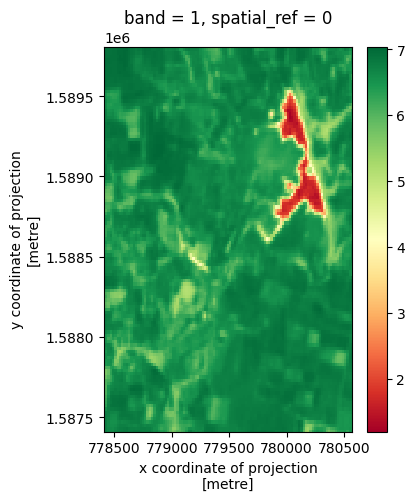

INFO:     49.204.96.248:0 - "GET /kpi-image/14.344822/14.366206/77.581514/77.601144/Evapo HTTP/1.1" 200 OK
INFO:     49.204.96.248:0 - "GET /visual-image/14.344822/14.366206/77.581514/77.601144/NDVI HTTP/1.1" 404 Not Found


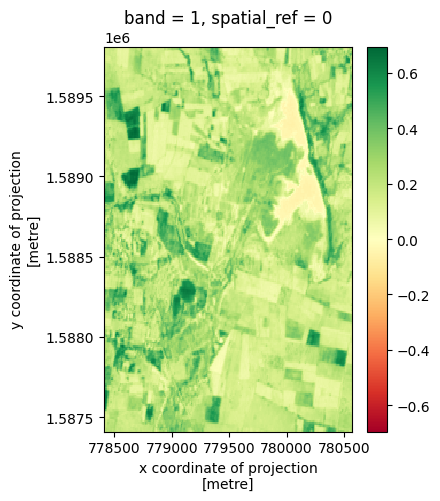

INFO:     49.204.96.248:0 - "GET /kpi-image/14.344822/14.366206/77.581514/77.601144/NDVI HTTP/1.1" 200 OK


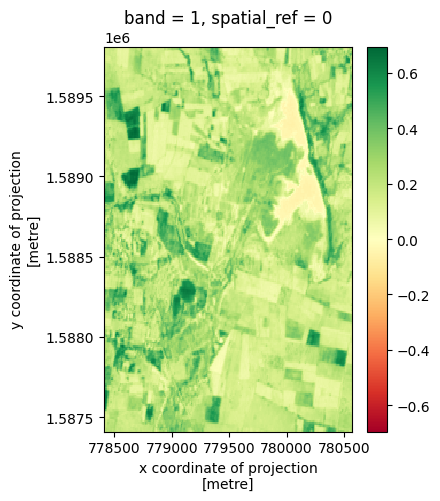

INFO:     49.204.96.248:0 - "GET /kpi-image/14.344822/14.366206/77.581514/77.601144/NDVI HTTP/1.1" 200 OK


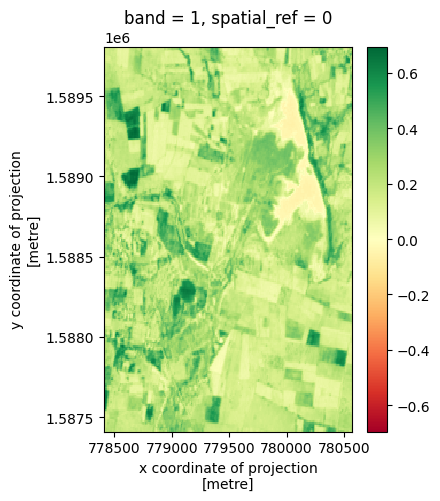

INFO:     49.204.96.248:0 - "GET /kpi-image/14.344822/14.366206/77.581514/77.601144/NDVI HTTP/1.1" 200 OK


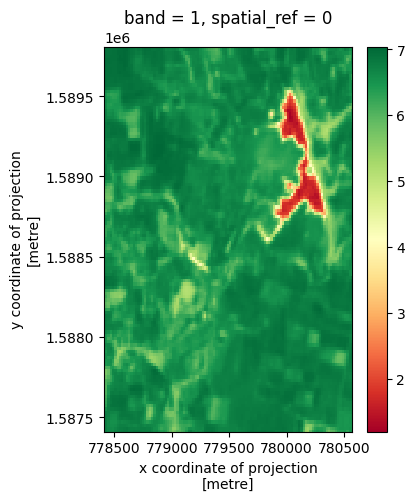

INFO:     49.204.96.248:0 - "GET /kpi-image/14.344822/14.366206/77.581514/77.601144/Evapo HTTP/1.1" 200 OK


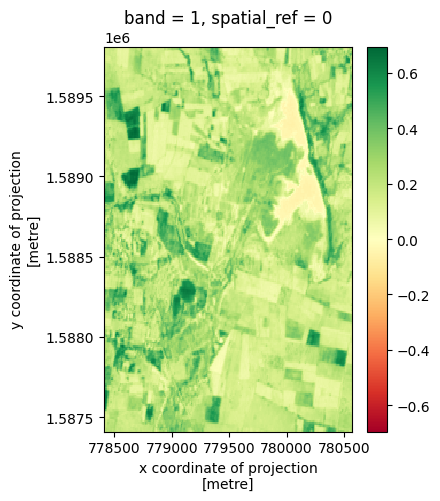

INFO:     49.204.96.248:0 - "GET /kpi-image/14.344822/14.366206/77.581514/77.601144/NDVI HTTP/1.1" 200 OK


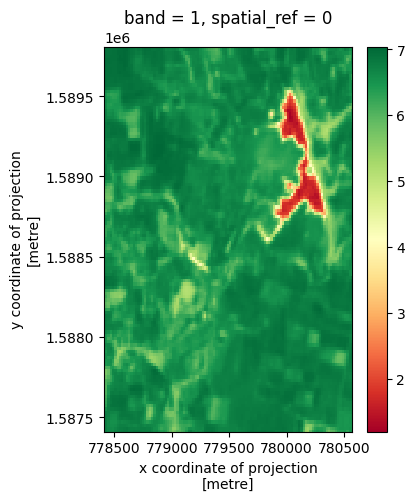

INFO:     49.204.96.248:0 - "GET /kpi-image/14.344822/14.366206/77.581514/77.601144/Evapo HTTP/1.1" 200 OK


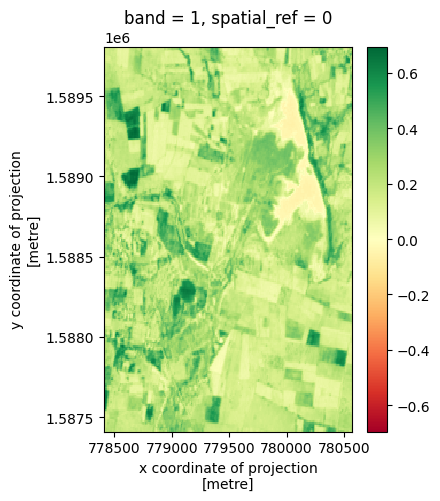

INFO:     49.204.96.248:0 - "GET /kpi-image/14.344822/14.366206/77.581514/77.601144/NDVI HTTP/1.1" 200 OK


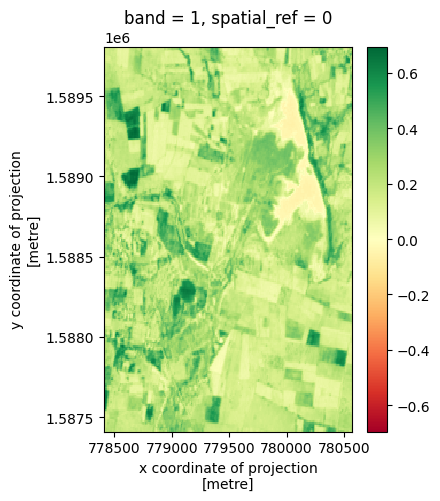

INFO:     49.204.96.248:0 - "GET /kpi-image/14.344822/14.366206/77.581514/77.601144/NDVI HTTP/1.1" 200 OK


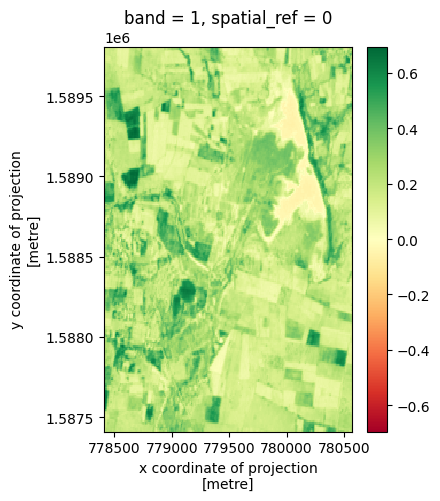

INFO:     49.204.96.248:0 - "GET /kpi-image/14.344822/14.366206/77.581514/77.601144/NDVI HTTP/1.1" 200 OK


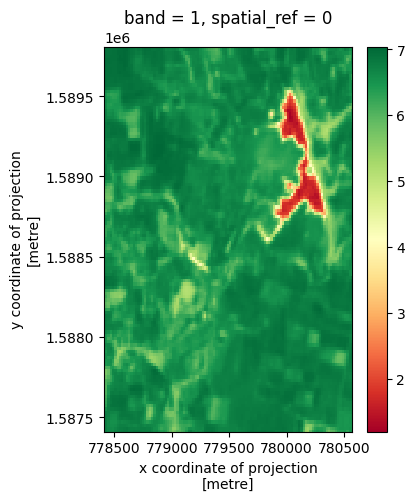

INFO:     49.204.96.248:0 - "GET /kpi-image/14.344822/14.366206/77.581514/77.601144/Evapo HTTP/1.1" 200 OK


In [ ]:
import nest_asyncio
from pyngrok import ngrok
import uvicorn
!ngrok authtoken 2RmoI9VV7y26cyn5THJ7sNUeAIv_7RtPiaCoquUKs1dcHtZfV

ngrok_tunnel = ngrok.connect(8000)
print('Public URL:', ngrok_tunnel.public_url)
nest_asyncio.apply()
uvicorn.run(app, port=8000)


In [ ]:
from shapely.geometry import Polygon

def create_bbox(lat1: float, lat2: float, long1: float, long2: float) -> Polygon:
    # Create a list of coordinates in the desired format
    lat1 = float(lat1)
    lat2 = float(lat2)
    long1 = float(long1)
    long2 = float(long2)
    coords = [(long1, lat1), (long2, lat1), (long2, lat2), (long1, lat2), (long1, lat1)]
    coords_pairs = [(lon, lat) for lat, lon in coords]
    # Create a Polygon object from the coordinates
    bbox = Polygon(coords_pairs)
    return bbox

# Usage example
bbox = create_bbox(14.344822, 14.366206, 77.581514, 77.601144)
print(bbox.bounds)  # Output: (77.581514, 14.344822, 77.601144, 14.366206)


(14.344822, 77.581514, 14.366206, 77.601144)


In [ ]:
t = bbox.bounds
type(t)

tuple

In [ ]:
y = (14.344822, 77.581514, 14.366206, 77.601144)
type(y)

tuple

In [ ]:
def get_image()
    # (with open , rb) = image_bytes
    image_bytes
    # media_type here sets the media type of the actual response sent to the client.
    return Response(content=image_bytes, media_type="image/png")

SyntaxError: ignored

#testing

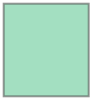

In [ ]:
from shapely.geometry import Polygon

# Convert the list of tuples to a list of coordinate pairs
coords = [(77.581514, 14.344822), (77.601144, 14.344822), (77.601144, 14.366206), (77.581514, 14.366206), (77.581514, 14.344822)]
coords_pairs = [(lon, lat) for lat, lon in coords]

# Create a Polygon object
polygon = Polygon(coords_pairs)

In [ ]:
coords_pairs

[(77.581514, 14.344822),
 (77.601144, 14.344822),
 (77.601144, 14.366206),
 (77.581514, 14.366206),
 (77.581514, 14.344822)]

In [ ]:
long1 = 77.581514
lat1 = 14.344822
long2 = 77.601144
lat2 = 14.366206

bbox = create_bbox(lat1, lat2, long1, long2)
print(bbox)

[(77.581514, 14.344822), (77.601144, 14.344822), (77.601144, 14.366206), (77.581514, 14.366206), (77.581514, 14.344822)]


In [ ]:
from typing import Tuple, List

def convert_coords(coords1: float, coords2: float, coords3: float, coords4: float) -> List[Tuple[float, float]]:
    coords = [(coords1, coords2), (coords3, coords2), (coords3, coords4), (coords1, coords4), (coords1, coords2)]
    return coords

coords1 = 77.581514
coords2 = 14.344822
coords3 = 77.601144
coords4 = 14.366206

coords = convert_coords(coords1, coords2, coords3, coords4)
print(coords)

[(77.581514, 14.344822), (77.601144, 14.344822), (77.601144, 14.366206), (77.581514, 14.366206), (77.581514, 14.344822)]


In [ ]:
14.344822/14.366206/77.581514/77.601144

In [ ]:
import json

coords = [(77.581514, 14.344822), (77.601144, 14.344822), (77.601144, 14.366206), (77.581514, 14.366206), (77.581514, 14.344822)]
# [(78.461,17.407),(78.487,17.407),(78.487,17.439),(78.461,17.439),(78.461,17.407)]
# Convert coords to JSON
coords_json = json.dumps(coords)

print(coords_json)

[[77.581514, 14.344822], [77.601144, 14.344822], [77.601144, 14.366206], [77.581514, 14.366206], [77.581514, 14.344822]]


In [ ]:
coords = json.loads(coords_json)
coords

[[77.581514, 14.344822],
 [77.601144, 14.344822],
 [77.601144, 14.366206],
 [77.581514, 14.366206],
 [77.581514, 14.344822]]

In [ ]:
/kpi-image/14.344822/14.366206/77.581514/77.601144/Evapo

In [ ]:
/visual-image/[[77.581514, 14.344822], [77.601144, 14.344822], [77.601144, 14.366206], [77.581514, 14.366206], [77.581514, 14.344822]]

In [ ]:
/visual-image/[[78.461,17.407],[78.487,17.407],[78.487,17.439],[78.461,17.439],[78.461,17.407]]

In [ ]:
kpi-image/[[77.581514, 14.344822], [77.601144, 14.344822], [77.601144, 14.366206], [77.581514, 14.366206], [77.581514, 14.344822]]/Evapo

In [ ]:
time-series/[[77.581514, 14.344822], [77.601144, 14.344822], [77.601144, 14.366206], [77.581514, 14.366206], [77.581514, 14.344822]]/ Evapo/ [[33, 82], [37, 64], [4, 122], [28, 137], [41, 137], [64, 110], [64, 54], [51, 36], [85, 25], [25, 16]]/ 5

In [ ]:
x1,y1 = 33,82
x2,y2 = 37, 64
x3,y3 = 4,122
x4,y4 = 28,137
x5,y5 = 41, 137
x6,y6 = 64,110
x7,y7 = 64,54
x8,y8 = 51,36
x9,y9 = 85,25
x10,y10 = 25,16
coordinate_list = [(x1, y1), (x2, y2), (x3, y3), (x4, y4), (x5, y5), (x6, y6), (x7, y7), (x8, y8), (x9, y9), (x10, y10)]

coordinate_json = json.dumps(coordinate_list)
print(coordinate_json)

[[33, 82], [37, 64], [4, 122], [28, 137], [41, 137], [64, 110], [64, 54], [51, 36], [85, 25], [25, 16]]


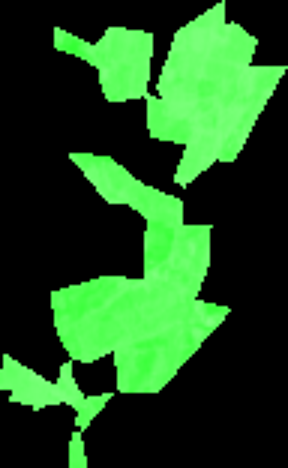

In [ ]:
import base64
from PIL import Image
import io
file_data_base64 = "iVBORw0KGgoAAAANSUhEUgAAAGAAAACcCAIAAAAPqjkNAAAZ40lEQVR4nO2daY8cV/XGn1tdvc6MZ4KQ8oqPwisSCQllUSAwJDjY8TK2I2exQEh8BBSJJWQlhIAhMRA2RUhIiLd8FxRibM/03l33/+KX+6QyY4/bPdU9Het/ZFkzPd1VdU+fe5bnLFe6r2kn7hzxCnklz7GCdDFeDAqFiiNeJ6vkaVaNno/PS4qKQeGIl7rfJOhKvILUZMokRcUjXvC+YtDleHmscVSsqab/l6AyXYqXMmWFikJFXlpUdmQdcj8waCfuBIWy7EgKCkcXH33elfSFeOF8PD/VdKxxocIcqamWK59oMtWUV56Lz813iwp4fFx0MV4sVNRUi4pjjYNCrjwoNNXMlE00GWucKePFqNhTT9Jb4a17usucDNqJO4WKX4Rf3NOnno/PFyrGGvP0hYrfht/OcfcL8UJUzJTBDnjEP0kNNQoVI42GGubKO+pExb763HGiya/Cr2a/15wMOhvPjjSaapor/3X49SwfeSm+NNZY0lBDlAXfv6SJJliciSbvhncPv86L8cWJJhNN4E5DDaubQsVU06aaE00GGvTUg0FBoatuVJxqOtJI0m/Cb2Zc6ZwMOhPPDDRAkieaNNW8qyygBQoVAw1qqtVUy5TVVIMv8GikUVBoqJErfz28fvAiL8YXsVZTTaNiXXUziBcLFR11kKCeeoWKhhpTTYca+j2SMmXvhHdmWen8VqypZq78I320q92GGk/EJ1pqvRfeu+2bd+IOmwI5t5/CXy0CLF7SnUKETFmmDMlFFkwoGriQKYNxE01y5X31fUGukCk7F89lyt4Mbx6+zDmtGNuEb0bSSKP/6r8f6+Mn4hPfid/Z9+Yz8cxQQ1QGkhIVWUZ55byITN3Jf0Ef8zarHjPIjJ5oMtIoU9ZRx38qe9XcYqrpuXju8JXOKUF99RHakUbm1FhjFNPT8emmmsjwTtyBm4UK3qkkIFNNeW5eZIPUVWcBB296JV6BO7lyhAWmWwHxQay7JXGsMTfizdzO2+2uvtKcDGqqeVM3BxqweLshLbVaavGe0/G0v2TUjZWxJMvRVFM2Au/x+w/elDXXVc+Vs3J+LV8N3T/RhP+VpEkSn+LivLlQcVdtPecWey+8hww31eTbsACPNa6r3la7rTZfda48V17+JpWCAJaBBMG+Mi/2UU21hhosj+uwSH7ls0EBjmPILNTIlJ8TuZslEJlfSf8z/JMfvhq/2lRzoIGknnowrq56U82xxrd0C5lCOhA0pJ1vm1fgox86P/BgL8YXRxrh+3mzSMLZgS+8yDfBpyyPURGBksTHZ4SKKojF/hH+wQ8Px4fRfHvaCwprWsNajTUea7ymNZ6bh7NObajBSqxQ9ulvU1/9gQZNNRFbxBOOIES4iMiLpLrqhj6QHb4kbjfL/qqGQSZk6sn4JDq7ULGhjZZaPC4Ph1jZA7Jh5vtHgjJlPwk/2XdxlI6NNNycasriecVqiPfDC/ioZLlUEqtZFlV9NP/H8EdJ347fHmo40aSlFh4dX2BLLT8xcsQu47OETujdMl2JV7AG5osVH/9zQSKYspbhW0GureBsyGZZzqKi+ffD+2210Zd11euqDzUcaTTRBNXTV7+nHuaPNxz+ldp4lwVNyduETRgs2ITC4lPIaVPNttpNNVtqtdWeMSJbeDS/HbdP6ERddZ4bMzTUsKce1p1wSZKDgFz5a+E1X+G5+Bz8RTrKCgi9y55qqIGSYuey17wBoyJ8mWqKhCLgSB8CxdfJ1fhsUFg4HnQtXBtosKa1TW221YZNLAxNxKNYs+oAkMyDttXe1GZLLQuRgy+MZnnLWBNbxyFcGH4EMFe+pjW+MJ4B0wmzcuVNNV8Lry0DMEO58gMuHAqloYY3l/1gWFb+OIE7/qEkfHe+9n32zjza52TDej6SK7db5L/ySFhbhMiPtAwGYW7LfopKX3I5SrI98mdPxVP+ztkCLM+LRBhZNkCiBcS2UpJDvLrqKD5QETYamouYtqUWge7Pws+0HEx6qmlffZZnLsAmJScFMbFr48+21Ya56F1U+0QTUB4UB8vrqVdX3YbfcYmlCdHwRvYmHWlk9zVTBuRi4HEZDBpquKe9sca41DyKHWsle88rQeGV8Io/axbAoKhIBFP2D8YaExXC94YaDTVqqrF54Q4KnjfANfsH9irLVtIPsIwt9kH4wKaXp8yVO85gkeyOfdqHZI4k9gKquqOOfXRvPXaHYcmxxugR+0dIWXl7KiGQcASLlilrq10GiZaU9gHZcxwP3FX2ax2mlfcXisPxARqdzVgOHbisVU85prdhsrDAmqaasIN/WIammgejnCWlfZBe1C0oEjKfK2c7OLgvM+iV8AroD/bOIUI5UoEdDTWsvGCZISElf4IH4D2Geh3EbWgD8fx5+PkxMOhauIaVcQ7LVgZfsa66zcfFeNEfdD6nbJJAVNtq4/vtw4CQhZZa7L6hhpjwfc4O+t673n/aR8tLHPJF7Wp3V7uZspZaPDHeh6RCxevhdR73Yrx4IV6Q9GZ406oEkSn/nNaQddRZ13pHnU1tbmnLHuBYY6PDbbXhb1fdgQa72sUX545ddXvqvRxePvDYS6ST8WRX3aaaa1pjr902jXcmnrHXv6Y1R+reZXgDCAWcwo2w5mbH2c0h3Guphabvq28HeqABAdpEk3J8Y1pqbv5quDrL23BM0OLWU2wZbzElUC0qDjUcaDDVlGXjBMI79A5hKoYCR4FwzD5BGczcR6tYvGCXBA1CfKDkfNv2WQcjF2woyxehDDk7NhdwGrpZKWSBZWON75QlXkUGYVmcOyMENxJWjmnt2rXU6qprdtgvx/yRO4TLbG2jS/sg2oO0igxyGofFIxGOEqxosOXkmstIviT0EcrLeTSzGLAFQ8FePiTLuorlLySIjAGyg+wf2Co7+0xI0VbbWWbiqbIzybaKigMNSFhJAiR4O7x9yMOsogRZZdpCjTVuq11GnYm80Nw11QykIClddVEu8No+usFynK+JJndFpleRQahPpb0WUuGPzbYkAnrUuV1ze0xwytCP9yky1VLLr7waXj38YVZxi/GtYqfLob/DetYMgmPYu6YaESleDzqL7WmTjzdIoL+v9uFOtIoSVE4xOl7H3rP7iC1ZORC1d1/ZV8KWEakVqaQKlxqH4K7io9WUoHfDuw4sQ6rWMGRh44Xaxn6TBO+og5k/oRNGF7nCWGNA6I46bL3bRl4HaRUlSMkVIviMqRzNxhv3h3y/0uJxArzsMvQx1JDwwmhGQ40yLHcIrSiDRho11cSQIyCGaBEcuIapAmZFuShVcTjRFhR2tYvyKucwZnySVa9y/Vr8Gg4xLg+ihB+8rvV1reMlkolUQuNy5bgFXXVHGv1P/yPa2NAGuP2Pwo9mfIAVlSDT38Pfy79+PX5dycEj5jTk7JqNUCqpGmvcV5/Y1RvzkMDiIK26BB1CO3EHjYNWcr4IHwczd13XBxpsavOGbgBpt9X+afjp7HdZRSs2I8EX9JEB1pBKGxxzSOqqKwldNmNZkGnVt9id6FQ81VST9SM+wGn4AZkyEkE4PkoJMkkzGi9TNQw6G8921d3TnpP/PPQ+DVItOWSz8UaUXACMwqaGBF0+Y210maphUKZsQxt11W/plnM4kh6Jj4w0IrbCqfl3+HdVd3RpMfE9bg5OtoExajlum3Sb+UZV0FvhLcrusCw8ELV1ddXXtf6AHgA2fTg+fPTbPRWfwiqVK6ZwmmDQRJNXw6vO5wDjz9gysY+qtGKPxce2tEUGnSLOqaYDDeqqb2jjpm7CuKh4p4L8Gel0PO0wAmGB+1S158p/HH5c0ZqqNvPbcZuoOlO2rvVc+S3dQv4pRzXKN9V0PjZtx22SIkYw8AyDAu0jb4Q3KlxRxWb+WrjWVBOpJnTc0AbNKRTBGOgZargdt+e4hdNbrjtAQ6PpquWOFuEHvRPeoZgMCKKppiSi7Sz1ubnk53Q8fa/Xt0+sUttuoeKN8Ma99q/NQgtxFF3gp5SrQfu4LrWmGgU+kk7FU7Nf+Uw8A/ZM9GDbNAuyMx8thEEvh5eNrgcFV00gVobBUCKZsu/G7854ZXqwOuq01OLnGXGvuWlRoQaV4DZbzkAQIrnaTKmB61w892x89q6X3VcMPNGkcqWzjxYbrL4UX8LSk73Ck3SyFKO2L7yexdm9FC911DlYaLAIWng0Ty0LtUxNNXvqUXTCHiF6ct1QSGWnmbLDE/mX4+V7jarmo4Uz6EK80FSz3MhbrgcfaEAeQlKROuVoasURn737dkG0DDzoSrwC5G42rWmNclwqu4vUVgcS5uxFpmxNa7nyu3aWLo6WBJi9EF8YaURvNtCni6f76qPFUVWgFqATZD6d5JlqOl88dRRaHqJ4OV5GuaBxnGJ3Au+GbsARPG9nCst1c9j4w7Pp1dJSIdeX4ktuLRloQOOJUiEHeAjl1MiXNxpIIIVVSN/SeLRURPG2QfbJeBL/SKmjAJ8AV9PFw0qpLv60tGc+fkz6arhKIwF5GzSOXaQsdQBT2Uj+h+KV5dBKYNLY8m/Fb7lYlzQO0uTifLeAzZg1roSOX4JMvw+/p+7C+dJpavAmd1wuQVzaU60QgyRdDVdDqdWr3HICxlaewrEcWi0GSXo3vHtd17vqMv3CJT8xtXQADyzteVZCB+0jquTMl7bazsHjGc2Xn5iPVjH1/Gh8lGQRThMlP+W6Ode+AAN4FJc75o+YFCjTKkqQK75d/kMlXV31B/VgljoUMfYgRID2vPmD8EGFD7NyDNqO2ziKBsbQ0PDFBYeu3XS8hu2r3ANYOQa5SB6NgyEjy16k6QF4AC7odc/LUMODUxuOSCvHIEZZuM2XjUNRKkEc426oISMF5AJzpTr8CmnlGNRRh+JewJAsDdJpqLGlLUBI8BDGwOA9gliGKuYj76OV84MQFvxmswmO0NKEt40/ua51EpNuH/P8q6po5SQIWIMiccuFSnWvRZpIIYliF5VKhO5/HUTZJU1xzj7SCwcq4rYfT0sp0vyYg2Mtjk4rt8Vu6uae9gx9KE0bOaET1IDztpAGVcFNivMXwaCVkyCngGzOkSa4A+PArQsVPfXctGDwqFpaOQaRoabDCUVDawG5/IEGoK7uMCe+d/+9E7ZV0coxKCrS4015vKRNbcIOikNcOuWxX54PME2TQSuklWNQTbWeelRbISkEYmwilDFuoTviyq0+7lioilaOQS4I2dRmXfXruj7SiAYmujHoQXQiqAxdjzWuPBO7cgzCY17TGsMrUUkP6IGbunld14lU8adp/glpflKRhpdWSyvHoHWt05ODT8y0IMfrVkA99SjcxP2hRX4RaOwyGPR4fFxpYoS1Cc7eQWTLzU8DDaLimtZ4kYwY+Nme9lzQChiE+zNHnfhdaYEMeig+VFNtXevgpOUggKApU3Y2nmU0C94wpQr2cTwdTpJr+D1RC9ZMSsP9F7GK6i+6Hbf3tAdyzDah24+YGxBjTWvAGqyzphoV6HDHnbusvK8+LjIxqhOtDt+5yIKS0dUwaDtu03oMyofp5VewLtQqOAboMjAFxS6upOqrj0NYpDNWpqWZoiON8AaZd1r2esLCwPUjMeix+BjxdF/9kKaT485hU9g7a1rjV5KCjNVE4zK4JaZRNu7MIb+MwWJcrvsNUMlUphdpBNoiggxoHgY9FZ+iA4siKNcc1tJ8RudtMNK8jT2CDuYH8vFR0cMngkJXXTCz+Nkx2uzWIg1aBBJRGva7uGKPeRjkeceSGNdG9MRSwXE88ceuipJupo+yq+4t3aJ517CGpKmmXXUdo/qDtTTNnWQGoFpMU5cq4MQdaB7J9BQWKukksXGsgxtqMDdCEtnRXDk9uMwf6aqLDIY0zUelQRRKXanEFg4m3ENPlO8aj/mOd5mR5pEg9pH7RaMiw0ScqMnSdBZ2H84L2ChDJ2EKrCQiNaCDy2OEUAlLNI/QO+Vi/p24w+3u9dyeWWgeBtm4FumUB+tL8FDck0k6bwUnhVzoDd1wQFBLo4DxmxknFtIZGA5B3VYIGluetoBs4kx31X00PrqnPUSvqmbHOSUIg40TaCDCNStERrRTMF6DSmAqpBETgDEl19nNeFTCSsK0eX9hE/kUbG2o0VMP/Y3dhGWYvy/HL1Nz1VHn/fD+3Aya0334SvzKVNOOOugCe3HYbFLpJ3TCJXVu8snS7EQ8Y8/ll4S2tnlC+8BiLqvUGsO9xhrvarejzoN6EC/hhm78R//x29zwsqWt34XfzbfSOf2gPB1vhqp23xbKdVObrI0gw33atvRKfrD/8bXjQ2al8aE41lka8Ivug4OM7KiptqtdXHMGLjAhyLBsU825uTM/gxikxtxZSbvadZH4hjY40gt4dJqGlLLOclarPD2ZBbNINp37VlwYO00TqZVmn+ZpBHeh4oROtNT6kr7EE9pxPSJCNL8EtdTqqIP5UGraYXaoe/xjGs9Lh7IHHblCo1Ya8EzwpTQmcJpmTWap5duVnb5gRx3QayWb+AV9ISre0A36ZpmWfwwMIg8zTcN1cf+dcmFhLqaL6WxGmzw0dy2d6cB7nAJUyVD6rBpfkHSzNziiykU4xoNDTphzx1TxY2BQlqbxUafiMVAEZY5FXXCZl2YYqrRBijRYHn4hGp4MgNq2MipUsG2R0Ikmu9oNCphUjjCEm7d0qyr4df4geDtuuyUVvuRpsLwDSLYDX6azei59xsQgUKgMJfliZ8F3Tztk+J+kXDmcAjlBx/fU29Oe1dxfwl+Ozh0dJZp33OgRfU74eYyIq1hi6dBcfvbEWSdzyoEbm5GN43nt3JFGs776oB94T+taB4TFHauwyGx+BuHFuoVCSbyzNN3abatmZV6a1VdLw7ZwhYrS8SAhzSml/4dNavyIRBD9VSONtrRV+/SQkGxd6/d0COZd6Ug400PxIWwWTKHacppm+E3TaRZ2/Aj9gdY8T5oowfrYH8fz9qStLI35ZSPjJU40+aK+uKWtoLCr3bHGR3Gab0tHAsxYvGEgcI8sjTuSZK2RpVMxJHl4lJK1QtPjUhIr4FIDhqDssejEKHk6UGyoIQOqkcrKuaMjVnf8K/zLOCFbA44Y5bK1lkSQaUHzdC1U7A3d+Fgff6SPbukW1R1o/aI0QMC6DJsIJqnkQM04rPpe6aiYtGEKTLu9YXQNBgjD5CpUsEGkiVCOmt6BBo4/UEa2ej4lFXVeS2f5oeDRhkfnxW2pAqz7kfgI0xDAwNa1bt8XR3mqKZBjuf3b9YcInSvHrb8oecGrJrHhSJXwlVIrYtEKK8f3UQVY94fhQ8ZPYY/t13nWKqU9WOi3w9tFOtqT8MqJIDiC30CDa7nut0inkBYq+upzu0zZpjYXxx2xxc7Gs4WKo6QlyxA1e8RDsIkYc+U+r8K545DG/EbFnno3dCNLZyOXU4NA3UZF3NLSUmtNa4tQzJ9dWpL2nbgz91U+DB9uaIOWE8foLrV8O7xdPs3DczRpFGdP7WkPbtIoLongrvjs8WE2jrxh0dyRUojE/ztxp6vuHBj4yXjSp3w/G591tHEny2LYtDxQ1KlXxxmIoUojcVDG1HRW25NxJ8r9cEqG82w8O3ua6VK8hL7wK3fdqmwobJy54wEV9jmRIFfVGSRE3v8c/jzXeu+ZPlHSmFtAr1z5xXiR088Pp0vxEn7tutZnv+XVcBWfUBLqxkW/Dk0w5CEdAVZL06NJE/wt/G2+1c5B+dl4NqSjglxlgc96IV6oq37IDBHjymX7PQvhRvM/sYUza0oD17M0f10lGZ9quiCH8E70SewTSudY8Ac0ZVPN78fv3+nDbMk5SpPBjA28OouP+VvTGrC/kxkeZV95If1d6ZMTT5z8N76nhBNGxR/GH440Ojivx+mXey3tytMh2a6EJsXI7C2ewW3O8I4nXP7sjsy8qKV2fknTdJiAe2pz5T+IPyh/8lQ8RXYctfpCfOEe7pqyXRYfB1nUsfoQcsMmTTWXY7b2P2pWOqWt/Ad8XINV8Ot78XuX42Xe4GInnv6e1JAxo3JkS5EdsL/Pg7DbuQSX5/aP6vynY2sLBe+wg+/DUbFx+IQEE4iDeXdXKh+EZU8HqDCkI52UTjbIlB0XdyTlGHi+QDv+Tn6ba0Wa8Jcpa6utZGvs4N1TPI2nQ5huDxCR3NMeSS6rxT+EPyxk6bPRZ6L58/F8rXS0kHefUxFICtlL7y/KUEA2uur+Mvxylhs/E5+hDuamblIcwz4FRdzSFvDjao3ouhgv2k8LpYNPQ+m8vKGGDGl1apQwqpYOGhxq6LDDdD6ed3XDsa/5nujTfXEqnioX3agUN/Ork6LUZebpYPiOOkXqL3XS6pn4jJLbUq7pPUZtMh99yiBXFRalc0rtmFkj8IpPpHbLpFIxWaHimfhMXXUcGS6CSfrccUd3QhQvxUvT0kEnVkYuWAJdZ0YoQ+7AsWzyKB27pVtKkxT+FP60xHVVRneHXE/H0z705ZBxfefiOap4mLjZVbeuOvA7ma+/hr9W+eDLorsz6Hw8HxVnmUT8zfhNYFDyMBTBkL1aZvxdLVVcoP54fNzYBaK0q93jdWSOSBUXqPv4HdRQV93PNXdULYPOxrPOzETFvvrXwrUKr38sVCWDyM8YXT9KZeDqUJUJSTJcRGqL6I68T+jp+PQ34jeO+ykqo+q7iDJlx4JsLYgqM/NPxidJdS56yPySqTIddLAx9f6gyrZYSKdTV3XBFaFqGPRUfMoV8ifjyUquuSJUzRYDMCOBlS1A8R8jVbMYqpaVkhOVXHNFqBoGTdLx8GVw9v6gahgEYARrZjyF+/NCVVox//BEfKKqyx47VcMgF7ry6xzlDCtLlVkx96BqkXMQlk/VrMT5VbcfVHLZVaD/AwaByOs4vUuSAAAAAElFTkSuQmCC"
# Decode the base64 data
file_data = base64.b64decode(file_data_base64)
# Open the image using PIL
image = Image.open(io.BytesIO(file_data))

# Get the current size of the image
width, height = image.size

# Double the size while maintaining aspect ratio
new_size = (width * 3, height * 3)

# Resize the image
resized_image = image.resize(new_size)

# Display the resized image
resized_image.show()

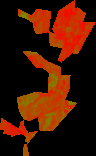

In [ ]:
image

In [ ]:
import glob
import shutil
import uuid
import io
import base64

from fastapi import Request
from PIL import Image

app = FastAPI()

app.add_middleware(
    CORSMiddleware,
    allow_origins=['*'],
    allow_credentials=True,
    allow_methods=['*'],
    allow_headers=['*'],
)
# global variables
phase_path = '/content/drive/MyDrive/ASCI/Anantgram/vectors/all_phases'
phase1_segments_path = '/content/drive/MyDrive/ASCI/Anantgram/vectors/phase_1/manual_tag'

@app.get("/kpi-image/{coords_json}/{kpi_name}")
def get_kpi_image(request: Request, coords_json, kpi_name):
    # polygon_input and conversion to the required CRS
    phase_file_list = sorted(glob.glob(os.path.join(phase_path, '*')))
    segments_file_list = glob.glob(os.path.join(phase1_segments_path, '*'))
    # converting the above phase and segment CRS to tile CRS
    coords = json.loads(coords_json)
    tiles = tile_pick(coords)
    crs = tiles[0].properties['proj:epsg']
    phase_list = vector_conversion(phase_file_list, crs)
    segments_list = vector_conversion(segments_file_list, crs)

    # download bands
    visual_dict, kpi_dict = temporal_data(coords, phase_list, kpi_name, 1)

    latest_kpi = list(kpi_dict.values())[0]
    scaled_kpi = (latest_kpi - latest_kpi.min()) * (255 / (latest_kpi.max() - latest_kpi.min()))
    # Convert the data type to uint8
    scaled_kpi = scaled_kpi.astype(np.uint8).values

    # Create an image from the array
    image = Image.fromarray(scaled_kpi)
    # latest_kpi.plot()
    # plt.show()

    # Convert the image data type to UInt16
    # latest_kpi = latest_kpi.astype("uint16")
    # latest_kpi.plot()
    # plt.show()

    # Generate a unique filename for the temporary file
    temp_filename = f"{uuid.uuid4().hex}.png"
    temp_file_path = os.path.join(temp_dir, temp_filename)
    image.save(temp_file_path, "PNG")
    # Save the latest_kpi as a temporary .png file
    # latest_kpi.rio.to_raster(temp_file_path)

    print("File path:", temp_file_path)

    # Transform the bounds to the target CRS
    bounds = latest_kpi.rio.bounds()
    target_crs = pyproj.CRS.from_epsg(4326)
    transformer = pyproj.Transformer.from_crs(crs, target_crs, always_xy=True)

    bounds_min = transformer.transform(bounds[0], bounds[1])
    bounds_max = transformer.transform(bounds[2], bounds[3])
    bbox = list(bounds_min) + list(bounds_max)

    # Retrieve the base URL of the server
    base_url = str(request.base_url)
    base_url = base_url.rstrip("/")
    # Construct the file URL
    file_url = f"{base_url}/temp/{temp_filename}"

    # Open the image using PIL
    image = Image.open(temp_file_path)

    # Display the image
    image.show()

    return {
        # "file_url": file_url,
        "bbox": bbox
    }

import tempfile

temp_dir = tempfile.gettempdir()
print('**********************************************')
print("temp_dir:", temp_dir)

import nest_asyncio
from pyngrok import ngrok
import uvicorn

ngrok_tunnel = ngrok.connect(8000)
public_url = ngrok_tunnel.public_url
print('Public URL:', public_url)
nest_asyncio.apply()
uvicorn.run(app, port=8000)


**********************************************
temp_dir: /tmp
Public URL: https://a5ab-34-23-131-77.ngrok.io


INFO:     Started server process [588]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [588]


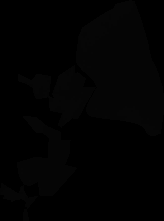

In [ ]:
import base64
from PIL import Image
from io import BytesIO

# Decode the base64 image data
base64_data = "iVBORw0KGgoAAAANSUhEUgAAAKQAAADdEAAAAABAY1rXAAAII0lEQVR4nO2d25rbIAyE5W6d93/e5OtuL7w4mAAWIMMIa/amzdH+MxLiYLyQ6UFERM+2D1kEDkSrHpHHqnH+bTgQrYoBJCL6afnQO4FMARTRXUKbA3Fz5KvuC/7Uvc0U6h4gS4J6rfuKe4DsoDs0Nvz82KDZGxtuUB9BVjQ4Mzvy0nIn1Kwgu0IkmjO0SyHG8mNxcM/Xanf34qa5HHmE+EPp8ztvpQs9OU+OHOREp1lCm1/mNFeMcc0Q2rlhsfD83GMcnEXBrT+0y0P6Ek/qBjk4L/rSHNoS9WJeBcGt1ZFAXtykE2QcY9iQdI02faGd9uIZyJpGhh3c2hx5FtIhrFzvRlSaQMLlRV96QJ5jdM6LufJy6ciRZV70c2Q7RGaW1ONIvhzALk500jBoAZ0bnTSAHCvmPLeBFBJ+jtwCm9tbcXWjTENTIHPkuVjBje7IB5U5q7sTncyRQsJ25BZUzmWx/ChbfDfIHMkRI0tiO/Itvx+9JB4fKnOkkLAHLd45MqV+TjwZvDBHCkkTSLdK4rLVEi3SBBJayDnSFR2pFru3L7NZ0hwpJC11pBNgdtxkjhSSBpCulV6QM7oGkCpkIPnKDl3ggqy8uHKUtLTaYWs9fPwxFK4jlUkryDH97Uy60QoSTgZSSAZSSAayTMksaSCFpAUkdD+bSA9IHCWCWwtIpHmaKEpckJVba40SLshNLjdi5ciIJzFBbgeqypNIv/OmI0S3ED9csTs+YwY/M5ojw6Bp3LC1n75GH4Cnlb72XPi9P/oP6hjf+vKOkZAcqeJqmrQwRshXymW9p4ZpBwRHnmPCbL8Pxz0a5MML6bBW9IP9BQpz19jyJ34x0nGBvQ8QL8T3o+OBfNB5IeL7h1O0pPcxC7MlMsoKkKE7Yq84Krcddfj6HEhklFUgN8Xdlga5fcfxXfkNPmJCRbkfV3lj84hguL4GXD18SM3OflR1rfYRZgrj8vsnJUyUv6ovfxzMcjdK+BcOJa8fm3rV1+n7Xc7z+6W1fecjvG+QPvhvn5vnSMwxGChXcvvaG8p3Ac3NfJ+rxuJt7vjxxUaV5cgnPYe5M+Y/DE+uRHWNjev3/vz+nWkBOeFLVdtq1zpTupiG+YlaRn9SJxG61P+fqyvD15zVmzDAolpbB3ZfVOaxej+m3/nC6DK2j0cevfLpxmvbYxCM4wd2WwWCUWbOJrVxOgWPhyctsSUhDEjNjgTCeN0soj9I62fRGhfCXVMTk4QjeaWJ9JgllB9plXIkZ7fl2qv/4d1I1DNHyvbRsfxIUiA/g9vvqcSCevH+cu+NCWut5K+uduSG+MGa0OULcBHLFTMqoUPD3VJCHfvi+f9vnw6HUbL8wR5WuFyjVqP5rXqsdQ+ff7sS0o+6ezZQ6uHIWG48y82pmhPUj9ocCZyHMVbsphXuoQvqR12OBPbjGEfW3JPriv42p2ZlS48jS+eHOquHI59eb1t61KfWRakatlpaHAmdH4n65sjUvbhyO96nnk995ply/f2FjiP7ReoDchv3qc9wmKvhDhozsvdGeubG7TVvkC3NzaVVwpiC3GU8HhYFftTT2DjBNjojQfL8GKLDRPkqDe1w/kU67HJXffmP5X6EVG0ZeyyVN4vr09YcWXrhnJTegEF6O+Wtdm6ivwRl6u5Jz4bracqgcs6dewenV035I4MyDlLW1Xmww0GeLT/hwPBP0Xfj9Tq/R45TSY6sBNmOMgayf72YP4suIFtRhiBHF925q3vP9bquZ/PIosHb3ccdQfWauZa+9tmXpvEcQeKV2PEzSzv01baB0tnWRn/CTYZ2+e/Dw0j0r3Dbpu/20Z+UK/2VEXGtmedQxN3p4NXe1+a0z2u0nkOHSFSUu9uveeZe8f0Z5vGwx1IsxD9zpUBoE5WVDhp8GCq2I4yvF5HUCPknynwNpgtnrjrZr9qQGY8srQPjWRNVrLOTGtgtL6k1oUxfU7mvZ79q8ouDSVOAr5Rm9aTMkzJfnZcmkERrhJUXh9dOx+Zh6gJJlJ0PuHpeO4dSH8iM+lxncwNdPx17E5TaFgjAqsfan5KKUa1/sRypFmMPkLp6MNXCcqRiGUghGUghGUghGUghGUghGUghGUghGUghGUghGUghIYFUPGSBBVK1DKSQJFbsfg6U1QSp6sBuHSGXHGu8Kchpd7ivVWlo32S8u1x8kIYwK05oX49QfWBb+SMmBJAT+BEltInU48QB6aQUKB5IJ2VAeQX58SL1XlKFEqGxiUsVxrKejbkxI1xHKlMJyH73SFDnR0xHKsTIH0brVwKpxIjnSKUY0UCqxVgyQm6DaVnhOFI1xrI5mys9qRxjmyMh7701SiUgr3ONej+WOjJ/5+JaHBNg3AYtJLYyqn//FBjfjuQ2JOFpL7TQyzD6w2g8X66/r3Hg2/bZmwZjOB65Zk8tfedDp6Vs88qC18IrbGzSO/Jwgr/En1NhJPobuW9C6vaknDkb7rzOZBjT5Y+t9CmUy5Gfd8sMfblEXxeKlyOn8+NZQf7I/qtWE2LcHJlzmfNlzZ3j4poSI6+L+Ahc2OLJSTHy57VlxnmmxegDKvMZd2tsXxNj9EHGdqOLa8uXPhYHb2pUebnQrqkbw/fcGGO6jjyXYTwoBJjOlM/92VjRfXOMaSc6oJ+NSjwJ3B5krvyJt8yxm9ffHmNtfYh+948Bal8gYBiJqM6R5yPlN1SbIw3jLpy1PzeVrrstAMswBqrtGlp2DGQ5UkgGUkiloV1/p+HJZY4UkoEUkoEUkoEUUj1IK8kPMkcKyUAKyUAK6T/x1XxZKGZwXgAAAABJRU5ErkJggg=="
image_data = base64.b64decode(base64_data)
image = Image.open(BytesIO(image_data))
image.show()